# Data Prep

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split


from sklearn.feature_selection import VarianceThreshold

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
import joblib

# Configuration
# sns.set_style("whitegrid")
# sns.set_context("notebook")
# sns.set_theme()

### 1. Load Data


In [2]:
df = pd.read_csv("../data/properties_cleaned.csv")
# df.head()

In [3]:

categoricalFeatures = df.select_dtypes(include=["object"]).columns.tolist()
continuousFeatures = df.select_dtypes(include=[np.number]).columns.tolist()
binaryFeatures = df.select_dtypes(include=bool).columns.tolist()

df[binaryFeatures] = df[binaryFeatures].astype(int)

allCategoricalFeatures = categoricalFeatures + binaryFeatures


In [4]:
# ==========================================
# 6. Data Prep for Linear Regression (Protected)
# ==========================================
print("\n" + "="*40 + "\n   DATA PREP FOR REGRESSION (15 PREDICTORS)\n" + "="*40)

# 0. Define Protected Features (Must NOT be removed)
protected_features = ['bedrooms', 'bathrooms', 'indoor_surface']
print(f"Protected Features (Will NOT be removed): {protected_features}")

# 1. Define Candidate Pool
# We combine valid continuous variables (excluding price) and all binary features
candidates = [col for col in continuousFeatures if col != 'price'] + binaryFeatures

# 2. Correlation Ranking
# Calculate absolute correlation with Price for all candidates
corr_matrix = df[candidates + ['price']].corr()
correlations = corr_matrix['price'].abs().sort_values(ascending=False).drop('price')

print("Top 20 Features by Correlation with Price:")
display(correlations.head(20).to_frame(name='Correlation'))

# 3. Iterative Feature Selection (VIF + Correlation with Protection)

# Start with Top 30 features + Ensure protected features are included
top_30 = correlations.head(30).index.tolist()
current_features = list(set(top_30 + protected_features))

print(f"\nInitial Feature Count: {len(current_features)}")
print("--- Starting Multicollinearity Reduction (Target: 15 Predictors) ---")

def calculate_vif(features, data):
    # VIF requires a design matrix (no NaNs, float type)
    X = data[features].dropna().astype(float)
    vif_data = pd.DataFrame()
    vif_data["Feature"] = features
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(features))]
    return vif_data.sort_values('VIF', ascending=False)

# Loop until we have exactly 15 features
while len(current_features) > 15:
    # Calculate VIF for current set
    vif_df = calculate_vif(current_features, df)
    
    # Filter out protected features so we don't drop them
    droppable_vif = vif_df[~vif_df['Feature'].isin(protected_features)]
    
    if droppable_vif.empty:
        print("Warning: Only protected features remain. Stopping reduction.")
        break
        
    worst_feature = droppable_vif.iloc[0]['Feature']
    max_vif = droppable_vif.iloc[0]['VIF']
    
    # Strategy:
    # 1. If highest VIF > 10 (High Multicollinearity), remove that feature.
    # 2. Else, remove the feature with the lowest correlation to Price.
    if max_vif > 10:
        print(f"   [Drop] {worst_feature} (High VIF: {max_vif:.2f}) - Redundant")
        current_features.remove(worst_feature)
    else:
        # Find droppable feature with lowest correlation
        droppable_feats = [f for f in current_features if f not in protected_features]
        least_correlated = correlations[droppable_feats].idxmin()
        corr_val = correlations[least_correlated]
        print(f"   [Drop] {least_correlated} (Low Corr: {corr_val:.4f}) - To meet target count")
        current_features.remove(least_correlated)

# 4. Final Selection
print("\n" + "="*30)
print("FINAL 15 PREDICTORS SELECTED")
print("="*30)
print(current_features)

# Show Final VIFs
print("\nFinal VIF Check:")
display(calculate_vif(current_features, df))

# 5. Create Final Model DataFrame
df = df[['price'] + current_features].copy()
print(f"\nModel Dataframe Created: {df.shape}")
display(df.head())


   DATA PREP FOR REGRESSION (15 PREDICTORS)
Protected Features (Will NOT be removed): ['bedrooms', 'bathrooms', 'indoor_surface']
Top 20 Features by Correlation with Price:


,Correlation
indoor_surface,0.738892
bathrooms,0.567389
bedrooms_from_title,0.514020
bedrooms,0.509674
private_pool,0.509559
private_garden,0.382367
u/f_heating_climate_control,0.355691
luxury,0.345941
communal_pool,0.310588
alarm_system_security,0.291381



Initial Feature Count: 30
--- Starting Multicollinearity Reduction (Target: 15 Predictors) ---


/home/sara/.local/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


   [Drop] bedrooms_from_title (High VIF: inf) - Redundant
   [Drop] electric_blinds_security (Low Corr: 0.1457) - To meet target count
   [Drop] solarium (Low Corr: 0.1559) - To meet target count
   [Drop] utility_room (Low Corr: 0.1607) - To meet target count
   [Drop] private_parking (Low Corr: 0.1724) - To meet target count
   [Drop] good_condition (Low Corr: 0.1792) - To meet target count
   [Drop] sauna (Low Corr: 0.1824) - To meet target count
   [Drop] heated_pool (Low Corr: 0.1929) - To meet target count
   [Drop] staff_accommodation (Low Corr: 0.1950) - To meet target count
   [Drop] basement (Low Corr: 0.2003) - To meet target count
   [Drop] pool_views (Low Corr: 0.2016) - To meet target count
   [Drop] guest_apartment (Low Corr: 0.2026) - To meet target count
   [Drop] more_than_one_parking (Low Corr: 0.2045) - To meet target count
   [Drop] fireplace_climate_control (Low Corr: 0.2085) - To meet target count
   [Drop] new_construction_condition (Low Corr: 0.2205) - To meet 

,Feature,VIF
10,bedrooms,9.263314
14,indoor_surface,7.347765
12,bathrooms,7.177222
0,communal_pool,6.407498
3,communal_garden,5.658659
5,private_pool,3.578461
6,private_garden,3.011429
9,luxury,1.752947
11,alarm_system_security,1.596234
7,barbeque,1.486769



Model Dataframe Created: (10229, 16)


,price,communal_pool,u/f_heating_climate_control,gym,communal_garden,domotics,private_pool,private_garden,barbeque,jacuzzi,luxury,bedrooms,alarm_system_security,bathrooms,games_room,indoor_surface
0,450000,1,0,0,1,0,0,0,0,0,0,3.0,0,2.0,0,120.0
1,749000,0,0,1,0,0,1,1,0,0,0,12.0,0,7.0,0,366.0
2,1695000,0,0,0,0,0,1,1,0,0,1,4.0,0,4.0,0,634.0
3,480000,0,0,0,0,0,1,1,0,0,0,4.0,0,2.0,0,130.0
4,850000,1,0,1,1,0,0,0,0,0,0,3.0,0,2.0,0,281.0


### Spliting into testing and training data

In [5]:
df_train_val, df_test = train_test_split(df, test_size=0.15, random_state=42)
df_train, df_val = train_test_split(df_train_val, test_size=0.15, random_state=42)

print(f"Original data shape: {df.shape}")
print(f"Training/Validation data shape: {df_train_val.shape}")
print(f"Test data shape: {df_test.shape}")

Original data shape: (10229, 16)
Training/Validation data shape: (8694, 16)
Test data shape: (1535, 16)


In [6]:
# Separate X and Y for training/validation and test sets
Y_train = df_train['price']
X_train = df_train.drop(columns=['price'])

Y_val = df_val['price']
X_val = df_val.drop(columns=['price'])

Y_test = df_test['price']
X_test = df_test.drop(columns=['price'])

### Preprocessing

In [7]:
Y_train_log = np.log1p(Y_train)
Y_val_log = np.log1p(Y_val)

In [8]:
all_numerical = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

discrete_features = [col for col in all_numerical if X_train[col].nunique() < 20] 
continuous_features = [col for col in all_numerical if col not in discrete_features]

print(f"Continuous features to log-scale: {len(continuous_features)}")
print(f"Discrete features (inc. bools) to minmax-scale: {len(discrete_features)}")
print(f"Categorical features to encode: {len(categorical_features)}")

Continuous features to log-scale: 2
Discrete features (inc. bools) to minmax-scale: 13
Categorical features to encode: 0


In [9]:
numerical_log_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(np.log1p, validate=False, feature_names_out="one-to-one")), 
    ('scaler', MinMaxScaler()) 
])

numerical_minmax_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()) 
])

categorical_transformer = OneHotEncoder(
    handle_unknown='ignore', 
    sparse_output=False, 
    dtype=int 
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num_log', numerical_log_transformer, continuous_features),
        ('num_minmax', numerical_minmax_transformer, discrete_features), # Bools (0/1) go here
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop',
    verbose_feature_names_out=False
).set_output(transform="pandas")

In [10]:
preprocessor.fit(X_train)

X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)

categorical_cols = [col for col in X_train_processed.columns if col not in (continuous_features + discrete_features)]

X_train_processed[categorical_cols] = X_train_processed[categorical_cols].astype(int) 
X_val_processed[categorical_cols] = X_val_processed[categorical_cols].astype(int)

try:
    feature_names = preprocessor.get_feature_names_out()
    print(f"\nTotal features after processing: {len(feature_names)}")
    print(f"Feature names: {feature_names.tolist()}")
except Exception as e:
    print(f"\nCould not get feature names: {e}")


Total features after processing: 15
Feature names: ['bathrooms', 'indoor_surface', 'communal_pool', 'u/f_heating_climate_control', 'gym', 'communal_garden', 'domotics', 'private_pool', 'private_garden', 'barbeque', 'jacuzzi', 'luxury', 'bedrooms', 'alarm_system_security', 'games_room']


In [11]:
X_train_processed["price_log"] = Y_train_log.values
X_train_processed["price_raw"] = df_train['price'].values # Original raw price

# For Validation Data
X_val_processed["price_log"] = Y_val_log.values
X_val_processed["price_raw"] = df_val['price'].values     # Original raw price

# For Test Data (Dirty/Raw)
# X_test is currently raw, so we just attach the raw price.
X_test["price_raw"] = Y_test.values

In [12]:
# Save Data
X_train_processed.to_csv("../data/training_data.csv", index=False)
X_test.to_csv("../data/testing_data_dirty.csv", index=False)
X_val_processed.to_csv("../data/validation_data.csv", index=False)
joblib.dump(preprocessor, "../models/pipeline.joblib")

FileNotFoundError: [Errno 2] No such file or directory: '../models/pipeline.joblib'


   VISUALIZING PROCESSED DISTRIBUTIONS


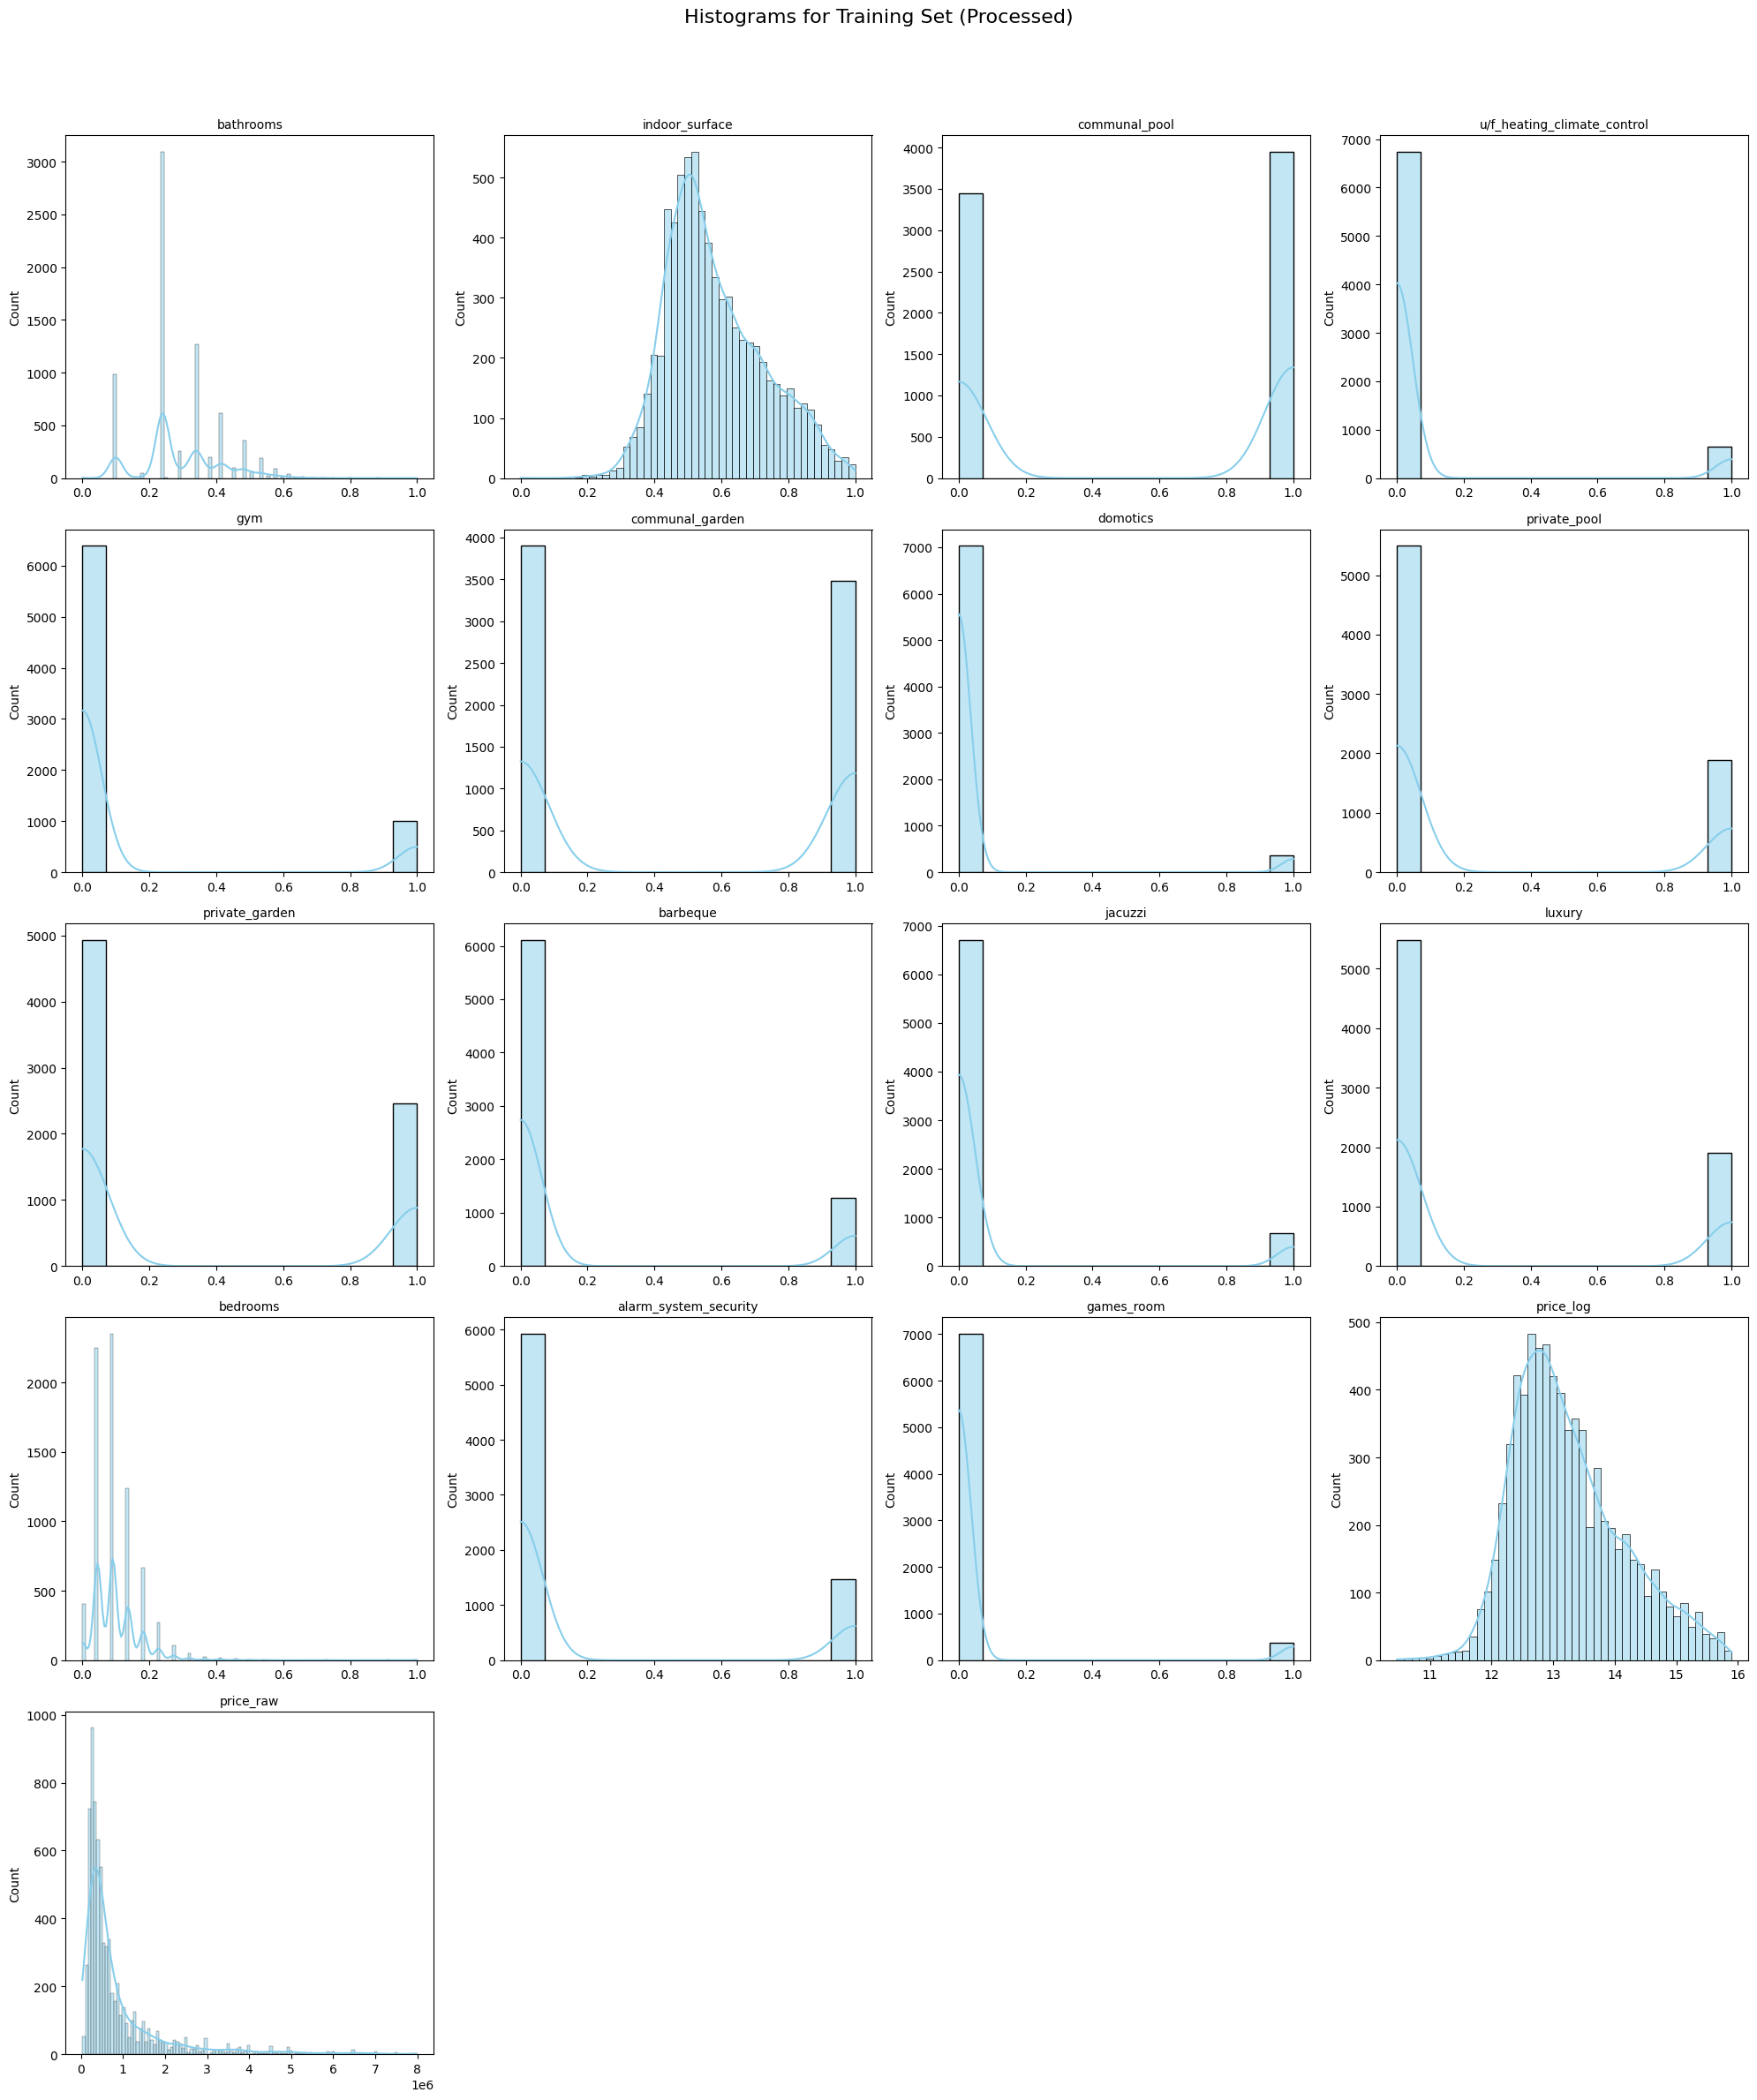

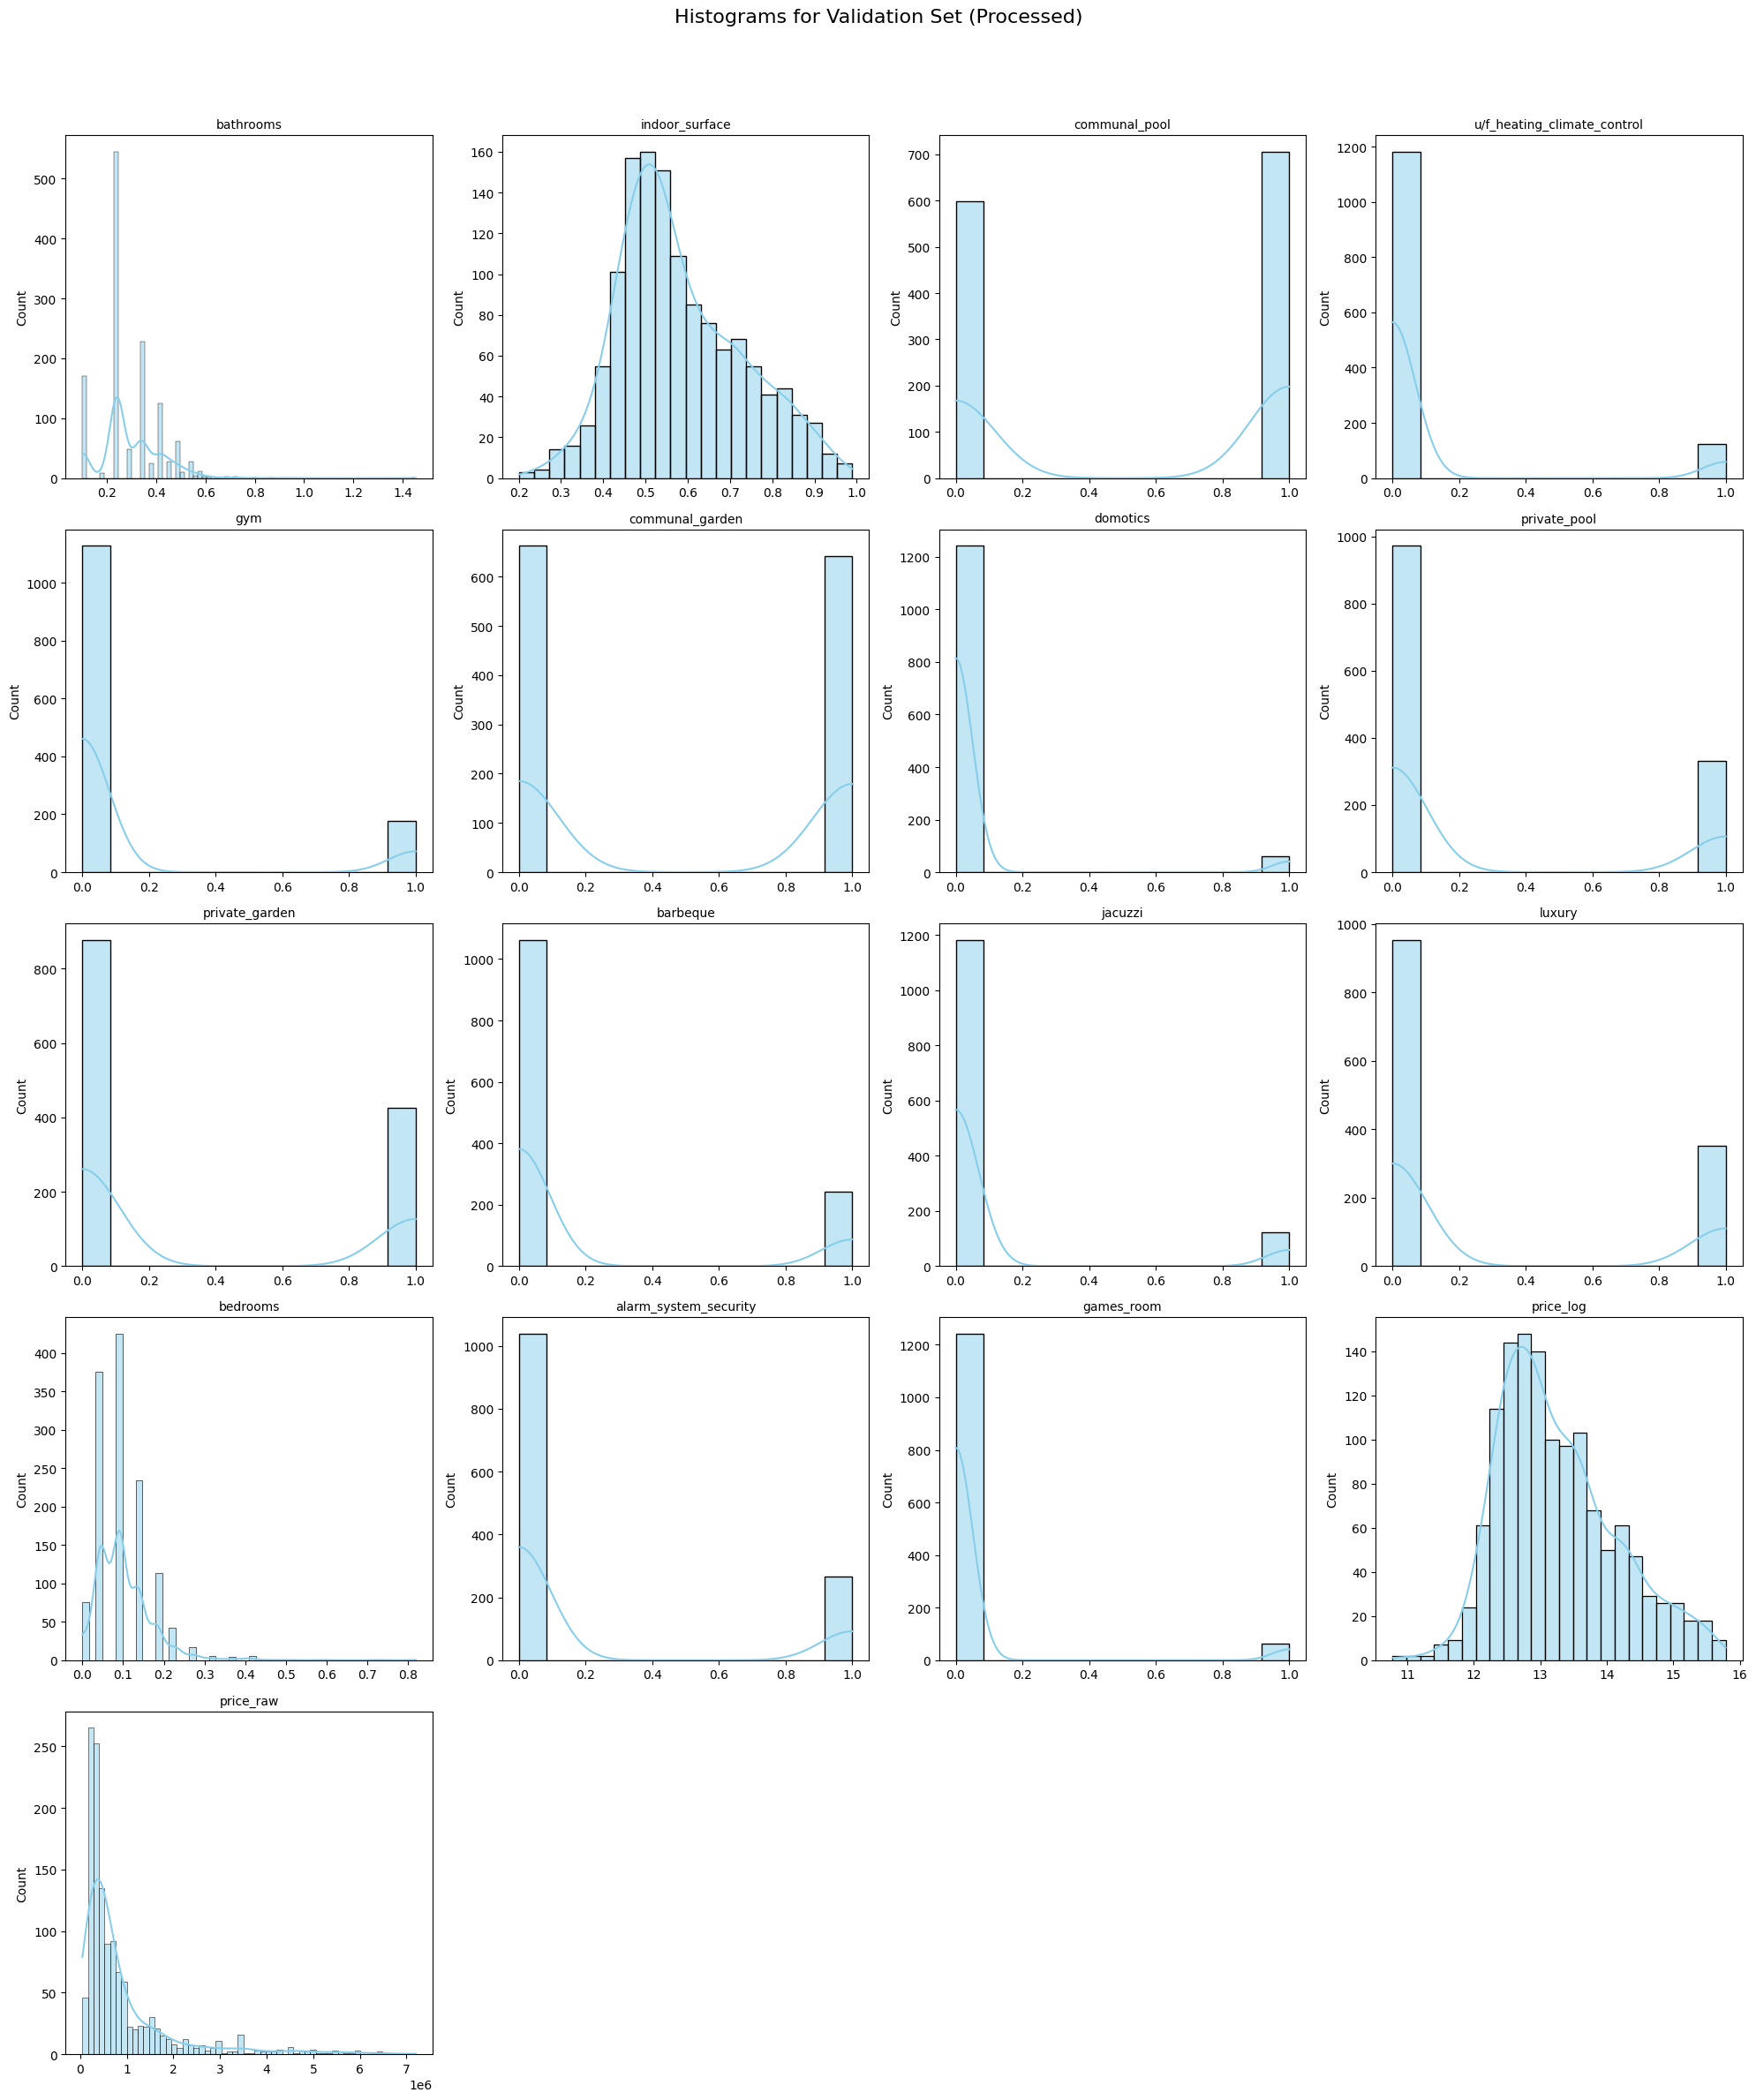

In [13]:
# ==========================================
# 7. Visualization of Processed Data
# ==========================================
print("\n" + "="*40 + "\n   VISUALIZING PROCESSED DISTRIBUTIONS\n" + "="*40)

def plot_histograms(df, dataset_name):
    """
    Plots histograms for all columns in the provided dataframe.
    """
    cols = df.columns
    num_cols = len(cols)
    
    # Determine grid size (e.g., 4 columns wide)
    n_cols_plot = 4
    n_rows_plot = math.ceil(num_cols / n_cols_plot)
    
    fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(20, 5 * n_rows_plot))
    fig.suptitle(f'Histograms for {dataset_name} (Processed)', fontsize=16)
    axes = axes.flatten()
    
    for i, col in enumerate(cols):
        sns.histplot(data=df, x=col, kde=True, ax=axes[i], color='skyblue', edgecolor='black')
        axes[i].set_title(f'{col}', fontsize=10)
        axes[i].set_xlabel('')
        
    # Hide empty subplots
    for i in range(num_cols, len(axes)):
        axes[i].axis('off')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
    plt.show()

# Plot for Training Data
plot_histograms(X_train_processed, "Training Set")

# Optional: Plot for Validation and Test to ensure distributions look similar
plot_histograms(X_val_processed, "Validation Set")